# Using a pretrained convnet - 5.3
## 1. Feature extraction

In [1]:
from tensorflow import keras

conv_base = keras.applications.vgg16.VGG16(
    weights="imagenet",
    include_top=False,
    input_shape=(150, 150, 3))
conv_base.trainable = False

Pass three arguments to the constructor:
1. $weights$ specifies the weight checkopint from which to initialize the model.
2. $include\_top$ refers to including the densely connected classifier on top of the network. By default, this densely connected classifier corresponds to the 1000 classes from ImageNet. Because we intend to use your own densely connected classifier, we don't need to include it.
3. $input\_shape$ is the shape of the image tensors that you'll feed to the network. optional argument

In [ ]:
conv_base.summary()

Before compiling and train model, it's very important to freeze the convolution base. *Freezing* a layer or set of layers means preventing their weights from being updated during training. If we don't do this, then representations that were previously learned by the conbolutional base will be modified during training. Because the $Dense$ layers on top are randoml initialized, very large weight updates would be propagated through the network, effectively destorying the representations previously learned

In [3]:
conv_base.trainable = True
print("This is the number of trainable weights "
      "before freezing the conv base:", len(conv_base.trainable_weights))

This is the number of trainable weights before freezing the conv base: 26


In [4]:
conv_base.trainable = False
print("This is the number of trainable weights "
      "after freezing the conv base:", len(conv_base.trainable_weights))

This is the number of trainable weights after freezing the conv base: 0


The final feature map has shape (4, 4, 512). That's the feature on top of which we'll stick a densely connected classifier.

Let's skip fast feature extraction without data augmentation. Here, we'll do extending the model by adding $Dense$ layers on top, and running the whole thing end to end on the input data. This will allow us to use data augmentation, because every input image goes through convolutional base every time it's seen by the model. But for the same reason, this technique is far more expensive than the first.

In [5]:
from tensorflow.keras import layers

# data augmentation
data_augmentation = keras.Sequential(
    [
        layers.experimental.preprocessing.RandomFlip("horizontal"),
        layers.experimental.preprocessing.RandomRotation(0.1),
        layers.experimental.preprocessing.RandomZoom(0.2),
    ])

# assemble model
inputs = keras.Input(shape=(150, 150, 3))
x = data_augmentation(inputs)
x = conv_base(x)
x = layers.Flatten()(x)
x = layers.Dense(256)(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)

# generating model
model = keras.Model(inputs, outputs)
model.compile(loss="binary_crossentropy",
              optimizer="rmsprop",
              metrics=["accuracy"])

Preparing train data and validation data

In [6]:
from tensorflow.keras import preprocessing
from tensorflow.keras.preprocessing import image_dataset_from_directory
import os

base_dir = '/home/ubuntu/dlp_fc/chpt5/data/cats_vs_dogs_small'

train_dataset = image_dataset_from_directory(
    os.path.join(base_dir, "train"),
    image_size=(150, 150),
    batch_size=32)

validation_dataset = image_dataset_from_directory(
    os.path.join(base_dir, "validation"),
    image_size=(150, 150),
    batch_size=32)

Found 2000 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.


With freezing convolution layer, only the weights from the two $Dense$ layers that we added will be trained. That's a total of four weight tensors: two per layer

In [ ]:
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="feature_extraction_with_data_augmentation.keras",
        save_best_only=True,
        monitor="val_loss")
]
history = model.fit(
    train_dataset,
    epochs=50,
    validation_data=validation_dataset,
    callbacks=callbacks)

In [36]:
model.save('cats_vs_dogs_small_pretrained-1.h5')

In [10]:
test_dataset = image_dataset_from_directory(
    os.path.join(base_dir, "test"),
    image_size=(150, 150),
    batch_size=32)

Found 2000 files belonging to 2 classes.


Evaluating the model on test set

In [38]:
test_model = keras.models.load_model(
    "feature_extraction_with_data_augmentation.keras")
test_loss, test_acc = test_model.evaluate(test_dataset)
print(f"Test accuracy: {test_acc:.3f}")

63/63 [==============================] - 10s 148ms/step - loss: 0.8763 - accuracy: 0.9490
Test accuracy: 0.949


Plotting the results

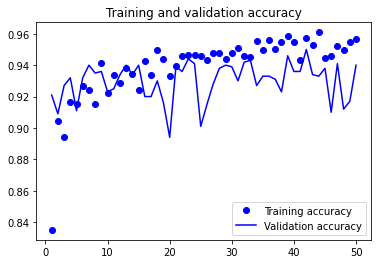

In [41]:
import matplotlib.pyplot as plt

acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, "bo", label="Training accuracy")
plt.plot(epochs, val_acc, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()

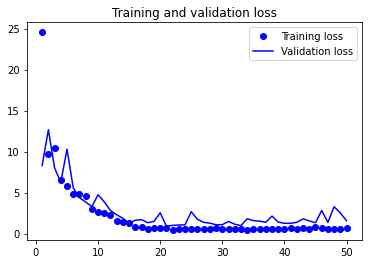

In [42]:
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()

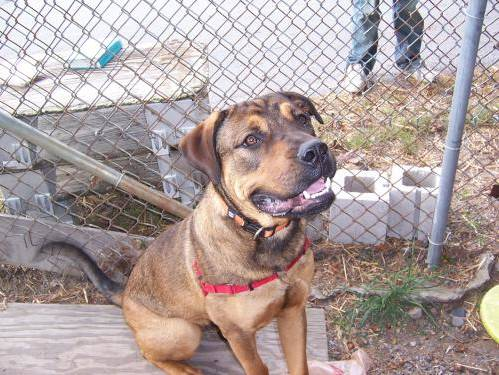

In [14]:
from IPython.display import Image

test_img_path = './data/cats_vs_dogs_small/test'
Image(filename = os.path.join(test_img_path, "dog/dog.2499.jpg"))

In [18]:
from keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale=1./255)
train_dir = "/home/ubuntu/dlp_fc/chpt5/data/cats_vs_dogs_small/train"
generator = train_datagen.flow_from_directory(train_dir,
                                              batch_size = 32,
                                              target_size = (150, 150),
                                              class_mode = 'binary')

Found 2000 images belonging to 2 classes.


In [19]:
from keras.models import load_model
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
import numpy as np

# load the model we saved
model = load_model('cats_vs_dogs_small_pretrained-1.h5')
model.compile(loss='binary_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])

# predicting images
img = image.load_img(os.path.join(test_img_path, "dog/dog.2499.jpg"), target_size=(150, 150))
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)

images = np.array(x)
prediction = model.predict(images, batch_size=32)
print(prediction)

label_map = generator.class_indices
label_map

[[1.]]


{'cat': 0, 'dog': 1}

Hundred percent it's a dog:)
## 2. Fine-tuning
Freezing all layers until the 4th from the last

In [7]:
conv_base.trainable = True
for layer in conv_base.layers[:-4]:
    layer.trainable = False

Fine-tuning the model

In [ ]:
model.compile(loss="binary_crossentropy",
              optimizer=keras.optimizers.RMSprop(learning_rate=1e-5),
              metrics=["accuracy"])

callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="fine_tuning.keras",
        save_best_only=True,
        monitor="val_loss")
]
history = model.fit(
    train_dataset,
    epochs=30,
    validation_data=validation_dataset,
    callbacks=callbacks)

Accuracy for test set.

In [11]:
model = keras.models.load_model("fine_tuning.keras")
test_loss, test_acc = model.evaluate(test_dataset)
print(f"Test accuracy: {test_acc:.3f}")

63/63 [==============================] - 10s 151ms/step - loss: 0.2516 - accuracy: 0.9355
Test accuracy: 0.936


Test for the single picture.

In [20]:
from keras.models import load_model
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
import numpy as np

# load the model we saved
model = load_model('fine_tuning.keras')
model.compile(loss='binary_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])

# predicting images
img = image.load_img(os.path.join(test_img_path, "dog/dog.2499.jpg"), target_size=(150, 150))
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)

images = np.array(x)
prediction = model.predict(images, batch_size=32)
print(prediction)

label_map = generator.class_indices
label_map
# hundred percent a dog

[[1.]]


{'cat': 0, 'dog': 1}